# Fine Tuning BERT For Classification 

## Imports and Setup




In [38]:
import torch  
import numpy as np 
import pandas as pd  
from torch import nn 
from torch.optim import Adam 
from transformers import BertTokenizer, BertForSequenceClassification  # BERT model and tokenizer
from tqdm import tqdm 
from peft import get_peft_model, LoraConfig  # For parameter-efficient fine-tuning of models
import os  

# Define the directory to save the output files
save_dir = 'output'
os.makedirs(save_dir, exist_ok=True)


## Data Loading and Preprocessing

This section involves loading the dataset from a CSV file, cleaning and preprocessing the data by removing unnecessary columns, splitting multi-label information into separate columns, and filtering labels based on their frequency. It also splits the data into training, validation, and test sets.


In [ ]:
# Load data from CSV file
df = pd.read_csv('test_food_bev_alc.csv')

# Clean the data by dropping unnecessary columns
data_cleaned = df.drop(columns=['link', 'typeID'])

# Split the 'label' column into multiple parts
label_split = data_cleaned['label'].str.split('/', expand=True)
label_split.columns = [f'label_part_{i+1}' for i in range(label_split.shape[1])]

# Combine the cleaned data with the split labels
data_expanded = pd.concat([data_cleaned.drop(columns=['label']), label_split], axis=1)

# Filter data to include labels with a minimum count
label_counts = data_expanded['label_part_2'].value_counts()
label_counts_cutoff = label_counts[label_counts >= 1000]
selected_labels = label_counts_cutoff.index
df_filtered = data_expanded[data_expanded['label_part_2'].isin(selected_labels)]

# Split data into training, validation, and test sets
df_train, df_val, df_test = np.split(df_filtered.sample(frac=1, random_state=35),
                                     [int(0.8*len(df_filtered)), int(0.9*len(df_filtered))])



## Tokenization and Dataset Preparation

This section initializes the BERT tokenizer and defines a custom PyTorch dataset class for handling text and label data. It maps labels to numerical values suitable for classification tasks.


In [39]:
# Map unique labels to numerical values for classification
unique_labels = df_filtered['label_part_2'].unique()
label_to_number = {label: idx for idx, label in enumerate(unique_labels, start=0)}

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a custom dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        # Store labels and texts
        self.labels = [label_to_number[label] for label in df['label_part_2']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['product']]
        
    def classes(self):
        # Return the class labels
        return self.labels
    
    def __len__(self):
        # Return the length of the dataset
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Return a specific batch of labels
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        # Return a specific batch of texts
        return self.texts[idx]
    
    def __getitem__(self, idx):
        # Retrieve a batch of texts and labels
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y


## Model Definition

This part defines the BERT-based sequence classifier model, incorporating a parameter-efficient fine-tuning technique (PEFT) using LoraConfig. The model uses BERT as a backbone for sequence classification tasks.


In [40]:
# Define the BERT-based sequence classifier
class BertSequenceClassifier(nn.Module):
    def __init__(self, num_classes: int):
        super(BertSequenceClassifier, self).__init__()
        # Load the pre-trained BERT model with sequence classification head
        self.bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
        
        # Configure parameter-efficient fine-tuning (PEFT) using LoraConfig
        peft_config = LoraConfig(
            task_type="SEQ_CLS",
            r=4,
            lora_alpha=32,
            lora_dropout=0.01,
            target_modules=['query', 'key', 'value'],
        )
        
        # Apply PEFT configuration to the model
        self.bert_model = get_peft_model(self.bert_model, peft_config)

    def forward(self, input_ids, attention_mask, labels=None):
        # Forward pass through the model
        return self.bert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)


## Training Setup



In [ ]:
# Determine the device to use (MPS, CUDA, or CPU)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Set training parameters
EPOCHS = 10
LR = 1e-4  

# Initialize the BERT sequence classifier and optimizer
model = BertSequenceClassifier(num_classes=len(unique_labels))
optimizer = Adam(model.parameters(), lr=LR)

# Display the device being used
print(f"Using device: {device}")
model.to(device)


## Training Loop



In [ ]:
# Define the training function
def train(model, train_data, val_data, epochs):
    # Prepare datasets and data loaders
    train, val = Dataset(train_data), Dataset(val_data)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=20, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=20)
    
    train_losses = []
    val_losses = []
    
    # Training over the specified number of epochs
    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        # Training phase
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)  # Move labels to device
            mask = train_input['attention_mask'].squeeze(1).to(device)  # Move attention mask to device
            input_id = train_input["input_ids"].squeeze(1).to(device)  # Move input IDs to device
            
            model.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(input_ids=input_id, attention_mask=mask, labels=train_label)
            loss = outputs.loss  # Compute loss
            logits = outputs.logits  # Get the logits
            
            total_loss_train += loss.item()  # Accumulate training loss
            
            acc = (logits.argmax(dim=1) == train_label).sum().item()  # Calculate accuracy
            total_acc_train += acc

            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            
        total_acc_val = 0
        total_loss_val = 0
        
        # Validation phase
        with torch.no_grad():  # No need to track gradients during validation
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].squeeze(1).to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                outputs = model(input_ids=input_id, attention_mask=mask, labels=val_label)
                loss = outputs.loss
                logits = outputs.logits
                
                total_loss_val += loss.item()
                
                acc = (logits.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
                
        avg_train_loss = total_loss_train / len(train_data)
        avg_val_loss = total_loss_val / len(val_data)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Print training and validation statistics
        print(
            f"Epochs: {epoch_num + 1} | Train Loss: {avg_train_loss: .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {avg_val_loss: .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")
    
    # Save the losses to .npy files in the specified save_dir
    np.save(os.path.join(save_dir, 'train_losses.npy'), np.array(train_losses))
    np.save(os.path.join(save_dir, 'val_losses.npy'), np.array(val_losses))
    print("Training and validation losses saved to train_losses.npy and val_losses.npy")
    
    # Save the model state dictionary
    torch.save(model.state_dict(), os.path.join(save_dir, 'bert_sequence_classifier.pth'))
    print(f"Model state dictionary saved to {os.path.join(save_dir, 'bert_sequence_classifier.pth')}")

# Start the training process
train(model, df_train, df_val, EPOCHS)


## Load the saved model

In [27]:
model = BertSequenceClassifier(num_classes=len(unique_labels))
# Load the saved state dictionary
model_path = "output/bert_sequence_classifier.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

print("Model loaded successfully.")


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Model loaded successfully.


## Testing Loop

In [37]:
import torch
import numpy as np
from sklearn.metrics import classification_report
from tqdm import tqdm

def evaluate(model, test_data):
    model.eval()  
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=8)
    
    predictions_labels = []
    true_labels = []
    total_acc_test = 0
    
    with torch.no_grad():
        for test_input, test_label in tqdm(test_dataloader):
            test_label = test_label.to(device)  
            mask = test_input['attention_mask'].squeeze(1).to(device) 
            input_id = test_input['input_ids'].squeeze(1).to(device)  

            outputs = model(input_ids=input_id, attention_mask=mask, labels=test_label) 
            logits = outputs.logits

            acc = (logits.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            true_labels += test_label.cpu().numpy().flatten().tolist()
            predictions_labels += logits.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    accuracy = total_acc_test / len(test_data)
    print(f'Test Accuracy: {accuracy: .3f}')
    
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions_labels, target_names=unique_labels))


    return true_labels, predictions_labels

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model.to(device)

true_labels, pred_labels = evaluate(model, df_test)


100%|██████████| 912/912 [01:27<00:00, 10.37it/s]


Test Accuracy:  0.900

Classification Report:
               precision    recall  f1-score   support

         beer       0.95      0.90      0.93       233
      spirits       0.91      0.92      0.91       175
         wine       0.95      0.98      0.96       371
        juice       0.91      0.90      0.91       141
         deli       0.69      0.68      0.68       287
  baked goods       0.86      0.88      0.87       413
        dairy       0.94      0.93      0.94       399
         meat       0.91      0.92      0.92       632
      seafood       0.83      0.88      0.85       220
fresh produce       0.92      0.94      0.93      1362
  frozen food       0.80      0.72      0.76       617
       pantry       0.93      0.93      0.93      2442

     accuracy                           0.90      7292
    macro avg       0.88      0.88      0.88      7292
 weighted avg       0.90      0.90      0.90      7292



In [30]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import plotly.graph_objects as go
from tqdm import tqdm

def evaluate(model, test_data):
    model.eval() 
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=8)
    
    predictions_labels = []
    true_labels = []
    total_acc_test = 0
    
    with torch.no_grad():
        for test_input, test_label in tqdm(test_dataloader):
            test_label = test_label.to(device)  
            mask = test_input['attention_mask'].squeeze(1).to(device) 
            input_id = test_input['input_ids'].squeeze(1).to(device)  

            outputs = model(input_ids=input_id, attention_mask=mask, labels=test_label)  
            logits = outputs.logits

            acc = (logits.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            true_labels += test_label.cpu().numpy().flatten().tolist()
            predictions_labels += logits.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    accuracy = total_acc_test / len(test_data)
    print(f'Test Accuracy: {accuracy: .3f}')
    
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions_labels, target_names=unique_labels))

    cm = confusion_matrix(true_labels, predictions_labels)

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cm_text = np.around(cm_normalized, decimals=2).astype(str)

    fig = go.Figure(data=go.Heatmap(
        z=cm_normalized,
        x=unique_labels,  
        y=unique_labels, 
        text=cm_text,  
        texttemplate="%{text}",  
        hoverongaps=False,
        colorscale='Viridis', 
        zmin=0, zmax=1
    ))

    fig.update_layout(
        title='Normalized Confusion Matrix',
        xaxis=dict(title='Predicted Label'),
        yaxis=dict(title='True Label'),
        margin=dict(l=50, r=50, t=50, b=50),
        height=1000, width=1000
    )

    fig.show()

    return true_labels, predictions_labels

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model.to(device)

true_labels, pred_labels = evaluate(model, df_test)


100%|██████████| 912/912 [01:18<00:00, 11.55it/s]

Test Accuracy:  0.900

Classification Report:
               precision    recall  f1-score   support

         beer       0.95      0.90      0.93       233
      spirits       0.91      0.92      0.91       175
         wine       0.95      0.98      0.96       371
        juice       0.91      0.90      0.91       141
         deli       0.69      0.68      0.68       287
  baked goods       0.86      0.88      0.87       413
        dairy       0.94      0.93      0.94       399
         meat       0.91      0.92      0.92       632
      seafood       0.83      0.88      0.85       220
fresh produce       0.92      0.94      0.93      1362
  frozen food       0.80      0.72      0.76       617
       pantry       0.93      0.93      0.93      2442

     accuracy                           0.90      7292
    macro avg       0.88      0.88      0.88      7292
 weighted avg       0.90      0.90      0.90      7292



# Comparing GPT2 and Bert

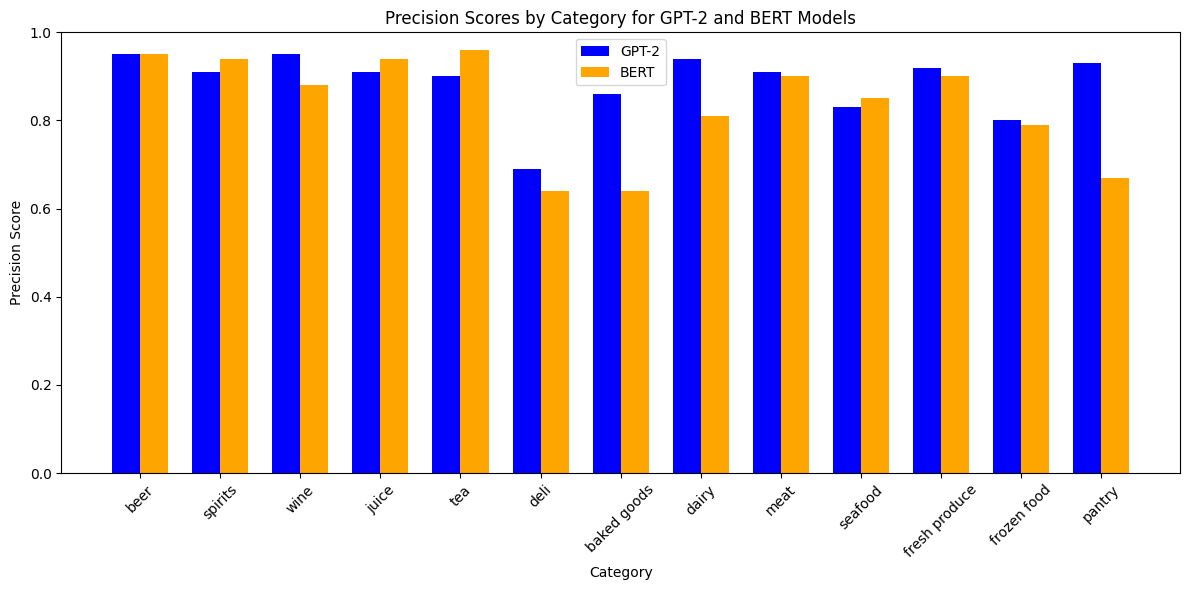

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Categories and precision scores for both models
categories = ['beer', 'spirits', 'wine', 'juice', 'tea', 'deli', 'baked goods', 'dairy', 'meat', 
              'seafood', 'fresh produce', 'frozen food', 'pantry']

gpt2_precision = [0.95, 0.91, 0.95, 0.91, 0.9, 0.69, 0.86, 0.94, 0.91, 0.83, 0.92, 0.80, 0.93]
bert_precision = [0.95, 0.94, 0.88, 0.94, 0.96, 0.64, 0.64, 0.81, 0.90, 0.85, 0.90, 0.79, 0.67]

bar_width = 0.35
index = np.arange(len(categories))

plt.figure(figsize=(12, 6))
plt.bar(index, gpt2_precision, bar_width, label='GPT-2', color='blue')
plt.bar(index + bar_width, bert_precision, bar_width, label='BERT', color='orange')

plt.xlabel('Category')
plt.ylabel('Precision Score')
plt.title('Precision Scores by Category for GPT-2 and BERT Models')
plt.xticks(index + bar_width / 2, categories, rotation=45)
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(
    x=categories,
    y=gpt2_precision,
    name='GPT-2',
    marker_color='blue'
))

fig.add_trace(go.Bar(
    x=categories,
    y=bert_precision,
    name='BERT Uncased',
    marker_color='orange'
))

fig.update_layout(
    title='Precision Scores by Category for GPT-2 and BERT Uncased Models',
    title_font_size=24,  
    xaxis_title='Category',
    xaxis_title_font_size=18, 
    yaxis_title='Precision Score',
    yaxis_title_font_size=18,  
    barmode='group',
    xaxis_tickangle=-45,
    xaxis_tickfont_size=14,  
    yaxis_tickfont_size=14,  
    yaxis_range=[0, 1],
    legend=dict(x=0.8, y=1.2, font_size=16),  
    width=1600, 
    height=800, 
    margin=dict(l=100, r=100, t=100, b=100)  
)


fig.show()
